In [ ]:
# ==============================================================================
# 1. IMPOR PUSTAKA
# ==============================================================================
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageStat
from pathlib import Path
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from zipfile import ZipFile
import json
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

In [ ]:
# ==============================================================================
# 1. IMPOR PUSTAKA
# ==============================================================================
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageStat
from pathlib import Path
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from zipfile import ZipFile
import json
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

In [ ]:
# ==============================================================================
# 2. KONFIGURASI GLOBAL
# ==============================================================================
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 10})
sns.set_style("whitegrid")
COLORS = sns.color_palette("Set2", 12)

CONFIG = {
    "DATASET_DIR": "/content/Garbage classification",
    "FLATTENED_DIR": "/content/Garbage_classification_flattened",
    "IMG_SIZE": (224, 224),
    "BATCH_SIZE": 32,
    "VAL_SPLIT": 0.2,
    "SEED": 42,
    "QUALITY_SAMPLE": 50,
    "VIS_SAMPLES_PER_CLASS": 4,
    "OUTPUT_DIR": "/content/output_results"
}

# Set semua seed untuk reproducibility
random.seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])
tf.random.set_seed(CONFIG["SEED"])

# Buat direktori output
Path(CONFIG["OUTPUT_DIR"]).mkdir(exist_ok=True)

print("=" * 75)
print("EKSPLORESI DAN PREPROCESSING DATASET — KLARIFIKASI SAMPAH")
print("=" * 75)
for k, v in CONFIG.items():
    if k != "FLATTENED_DIR":
        print(f"{k.replace('_', ' ').title():>25}: {v}")
print("=" * 75)

EKSPLORESI DAN PREPROCESSING DATASET — KLARIFIKASI SAMPAH
              Dataset Dir: /content/Garbage classification
                 Img Size: (224, 224)
               Batch Size: 32
                Val Split: 0.2
                     Seed: 42
           Quality Sample: 50
    Vis Samples Per Class: 4
               Output Dir: /content/output_results


In [ ]:
# ==============================================================================
# 3. FUNGSI UTILITAS
# ==============================================================================
def flatten_dataset_structure(src_root: str, dst_root: str):
    """Memindahkan semua gambar dari subfolder ke dalam 2 folder utama"""
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    dst_root.mkdir(exist_ok=True)

    parent_classes = ["Organik", "anorganik"]
    for parent in parent_classes:
        (dst_root / parent).mkdir(exist_ok=True)
        parent_path = src_root / parent
        if not parent_path.exists():
            raise FileNotFoundError(f"Folder {parent_path} tidak ditemukan!")

        for subfolder in sorted(parent_path.iterdir()):
            if subfolder.is_dir():
                print(f"Memproses: {parent}/{subfolder.name} → {parent}/")
                for img_file in subfolder.iterdir():
                    if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                        new_name = f"{subfolder.name}_{img_file.name}"
                        shutil.copy2(img_file, dst_root / parent / new_name)

    print(f"Dataset telah diratakan ke: {dst_root}")

def analyze_image_quality(df_meta: pd.DataFrame, n_samples: int = 50) -> pd.DataFrame:
    """Analisis kualitas gambar"""
    quality_data = []
    for _, row in df_meta.iterrows():
        img_files = [f for f in os.listdir(row['path'])
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        sampled = random.sample(img_files, min(n_samples, len(img_files)))
        for fname in sampled:
            fpath = os.path.join(row['path'], fname)
            try:
                with Image.open(fpath) as img:
                    w, h = img.size
                    if w == 0 or h == 0: continue
                    fs_kb = os.path.getsize(fpath) / 1024
                    stat = ImageStat.Stat(img.convert('RGB'))
                    brightness = np.mean(stat.mean)
                    ar = w / h
                    quality_data.append({
                        'category': row['category'],
                        'parent': row['parent'],
                        'width': w,
                        'height': h,
                        'aspect_ratio': ar,
                        'file_size_kb': fs_kb,
                        'brightness': brightness
                    })
            except:
                continue
    return pd.DataFrame(quality_data)

def visualize_sample_images(df_meta: pd.DataFrame, n_per_class: int = 4):
    """Visualisasi contoh gambar per kelas"""
    n_classes = len(df_meta)
    fig, axes = plt.subplots(n_classes, n_per_class, figsize=(n_per_class * 2, n_classes * 2))
    if n_classes == 1:
        axes = axes.reshape(1, -1)
    elif n_per_class == 1:
        axes = axes.reshape(-1, 1)

    for i, (_, rec) in enumerate(df_meta.iterrows()):
        img_files = [f for f in os.listdir(rec['path'])
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        selected = random.sample(img_files, min(n_per_class, len(img_files)))
        for j, img_name in enumerate(selected):
            ax = axes[i, j] if n_classes > 1 and n_per_class > 1 else (axes[j] if n_classes == 1 else axes[i])
            try:
                img = Image.open(os.path.join(rec['path'], img_name))
                ax.imshow(img)
                ax.set_title(f"{rec['category']}\n{img.size[0]}×{img.size[1]}", fontsize=9, fontweight='bold')
            except:
                ax.text(0.5, 0.5, 'Error', ha='center', va='center')
            ax.axis('off')
    plt.suptitle("Contoh Gambar per Kelas", fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def get_class_counts(gen):
    """Menghitung jumlah sampel per kelas dalam generator"""
    gen.reset()
    steps = (gen.samples + gen.batch_size - 1) // gen.batch_size
    counts = np.zeros(gen.num_classes, dtype=int)
    for _ in range(steps):
        try:
            _, y = next(gen)
            for label in y:
                counts[np.argmax(label)] += 1
        except:
            break
    gen.reset()
    return counts

In [ ]:
# ==============================================================================
# 4. EKSTRAKSI DAN FLATTEN DATASET
# ==============================================================================
zip_path = "/content/Garbage classification.zip"
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

print("Dataset berhasil diekstrak")

flatten_dataset_structure(CONFIG["DATASET_DIR"], CONFIG["FLATTENED_DIR"])

Dataset berhasil diekstrak
Memproses: Organik/Buah → Organik/
Memproses: Organik/Bunga → Organik/
Memproses: Organik/Daging → Organik/
Memproses: Organik/Daun → Organik/
Memproses: Organik/Makanan → Organik/
Memproses: Organik/campuran → Organik/
Memproses: anorganik/cardboard → anorganik/
Memproses: anorganik/glass → anorganik/
Memproses: anorganik/metal → anorganik/
Memproses: anorganik/paper → anorganik/
Memproses: anorganik/plastic → anorganik/
Dataset telah diratakan ke: /content/Garbage_classification_flattened


In [ ]:
# ==============================================================================
# 5. PEMETAAN STRUKTUR DATASET & VERIFIKASI INTEGRITAS
# ==============================================================================
print("\n[1/6] Memetakan struktur dataset asli dan memverifikasi integritas file...")

dataset_root = Path(CONFIG["DATASET_DIR"])
parent_classes = ["Organik", "anorganik"]
subfolder_info = []

for parent in parent_classes:
    parent_path = dataset_root / parent
    if not parent_path.exists():
        raise FileNotFoundError(f"Folder {parent_path} tidak ditemukan!")

    for subfolder in sorted(parent_path.iterdir()):
        if subfolder.is_dir():
            valid = 0
            corrupt = 0
            for img_file in subfolder.iterdir():
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    try:
                        with Image.open(img_file) as img:
                            img.verify()
                        valid += 1
                    except:
                        corrupt += 1
            subfolder_info.append({
                'parent': parent,
                'category': subfolder.name,
                'path': str(subfolder),
                'valid': valid,
                'corrupt': corrupt
            })
            print(f"  {parent}/")
            print(f"    {subfolder.name}: {valid} valid, {corrupt} corrupt")

df_meta = pd.DataFrame(subfolder_info)
df_meta['count'] = df_meta['valid']
total_valid = df_meta['count'].sum()
print(f"\nTotal gambar valid: {total_valid}")


[1/6] Memetakan struktur dataset asli dan memverifikasi integritas file...
  Organik/
    Buah: 400 valid, 0 corrupt
  Organik/
    Bunga: 400 valid, 0 corrupt
  Organik/
    Daging: 400 valid, 0 corrupt
  Organik/
    Daun: 400 valid, 0 corrupt
  Organik/
    Makanan: 400 valid, 0 corrupt
  Organik/
    campuran: 400 valid, 0 corrupt
  anorganik/
    cardboard: 400 valid, 0 corrupt
  anorganik/
    glass: 400 valid, 0 corrupt
  anorganik/
    metal: 400 valid, 0 corrupt
  anorganik/
    paper: 400 valid, 0 corrupt
  anorganik/
    plastic: 400 valid, 0 corrupt

Total gambar valid: 4400



ANALISIS DISTRIBUSI KELAS — STATISTIK DESKRIPTIF
Jumlah Kelas                  :       11
Total Gambar                  :     4400
Rata-rata                     :   400.00
Median                        :   400.00
Standar Deviasi               :     0.00
Koefisien Variasi (%)         :     0.00%
Skewness (Pearson)            :        0
Minimum                       :      400
Maksimum                      :      400
Rentang                       :        0
Rasio Imbalance (Max/Min)     :     1.00×


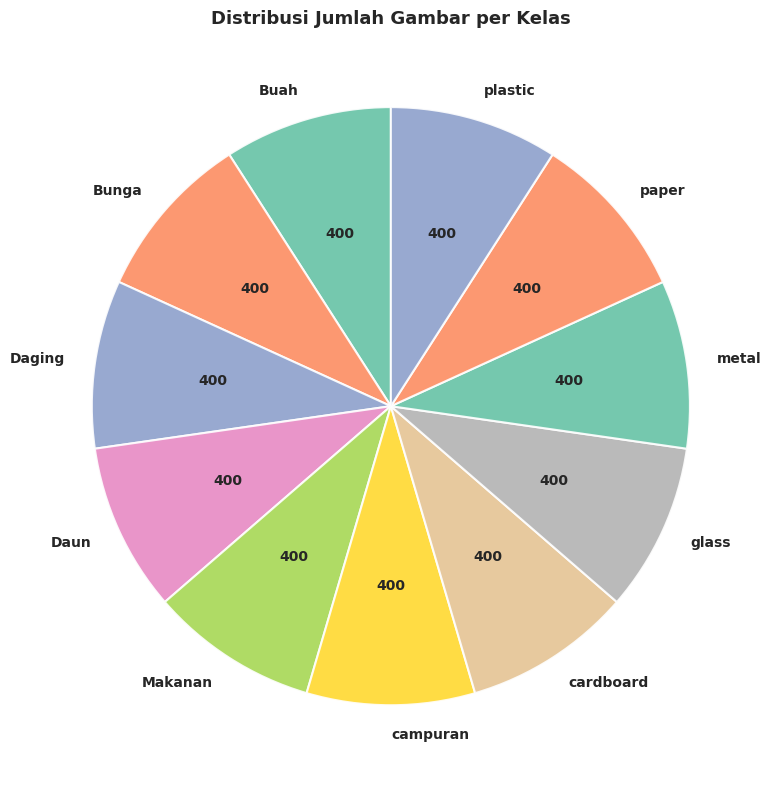

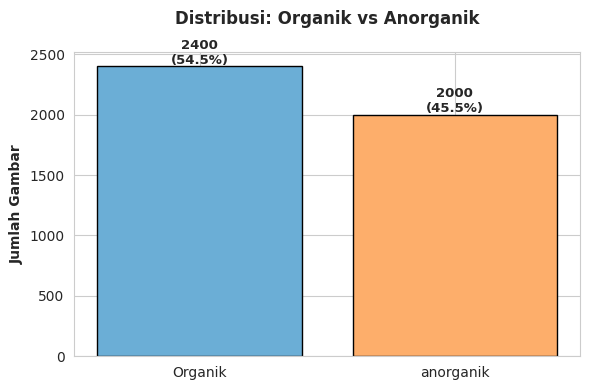

In [ ]:
# ==============================================================================
# 6. ANALISIS DISTRIBUSI KELAS — STATISTIK & VISUALISASI
# ==============================================================================
print("\n" + "="*60)
print("ANALISIS DISTRIBUSI KELAS — STATISTIK DESKRIPTIF")
print("="*60)

counts = df_meta['count'].values
categories = df_meta['category'].values

mean_val = np.mean(counts)
median_val = np.median(counts)
std_val = np.std(counts)
cv_pct = (std_val / mean_val) * 100 if mean_val > 0 else 0
skewness = (3 * (mean_val - median_val)) / std_val if std_val != 0 else 0

descriptive_stats = {
    "Jumlah Kelas": len(counts),
    "Total Gambar": np.sum(counts),
    "Rata-rata": mean_val,
    "Median": median_val,
    "Standar Deviasi": std_val,
    "Koefisien Variasi (%)": cv_pct,
    "Skewness (Pearson)": skewness,
    "Minimum": np.min(counts),
    "Maksimum": np.max(counts),
    "Rentang": np.max(counts) - np.min(counts),
    "Rasio Imbalance (Max/Min)": np.max(counts) / np.min(counts) if np.min(counts) > 0 else 0
}

for k, v in descriptive_stats.items():
    if isinstance(v, float):
        if "Koefisien" in k:
            print(f"{k:<30}: {v:>8.2f}%")
        elif "Rasio" in k:
            print(f"{k:<30}: {v:>8.2f}×")
        else:
            print(f"{k:<30}: {v:>8.2f}")
    else:
        print(f"{k:<30}: {v:>8}")

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=categories,
    autopct=lambda pct: f"{int(pct/100.*sum(counts))}",
    startangle=90,
    colors=COLORS[:len(categories)],
    textprops={'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5, 'alpha': 0.9}
)
ax.set_title("Distribusi Jumlah Gambar per Kelas", fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

parent_summary = df_meta.groupby('parent')['count'].sum().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(parent_summary.index, parent_summary.values,
              color=['#6baed6', '#fdae6b'][:len(parent_summary)],
              edgecolor='black')
ax.set_ylabel("Jumlah Gambar", fontweight='bold')
ax.set_title("Distribusi: Organik vs Anorganik", fontweight='bold', pad=20)
for bar, count in zip(bars, parent_summary.values):
    pct = count / parent_summary.sum() * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            f"{int(count)}\n({pct:.1f}%)", ha='center', fontweight='bold', fontsize=9.5)
plt.tight_layout()
plt.show()


[2/6] Analisis kualitas gambar...

ANALISIS KUALITAS GAMBAR — STATISTIK
         width   height  aspect_ratio  file_size_kb  brightness
count   550.00   550.00        550.00        550.00      550.00
mean    382.40   288.21          1.36         15.22      150.62
std     146.04   113.66          0.30         51.64       40.40
min      87.00   125.00          0.39          2.41       29.92
25%     260.00   185.00          1.33          8.23      121.27
50%     318.00   244.50          1.33         12.00      156.22
75%     512.00   384.00          1.47         15.91      178.14
max    1920.00  1429.00          3.23       1212.94      239.10


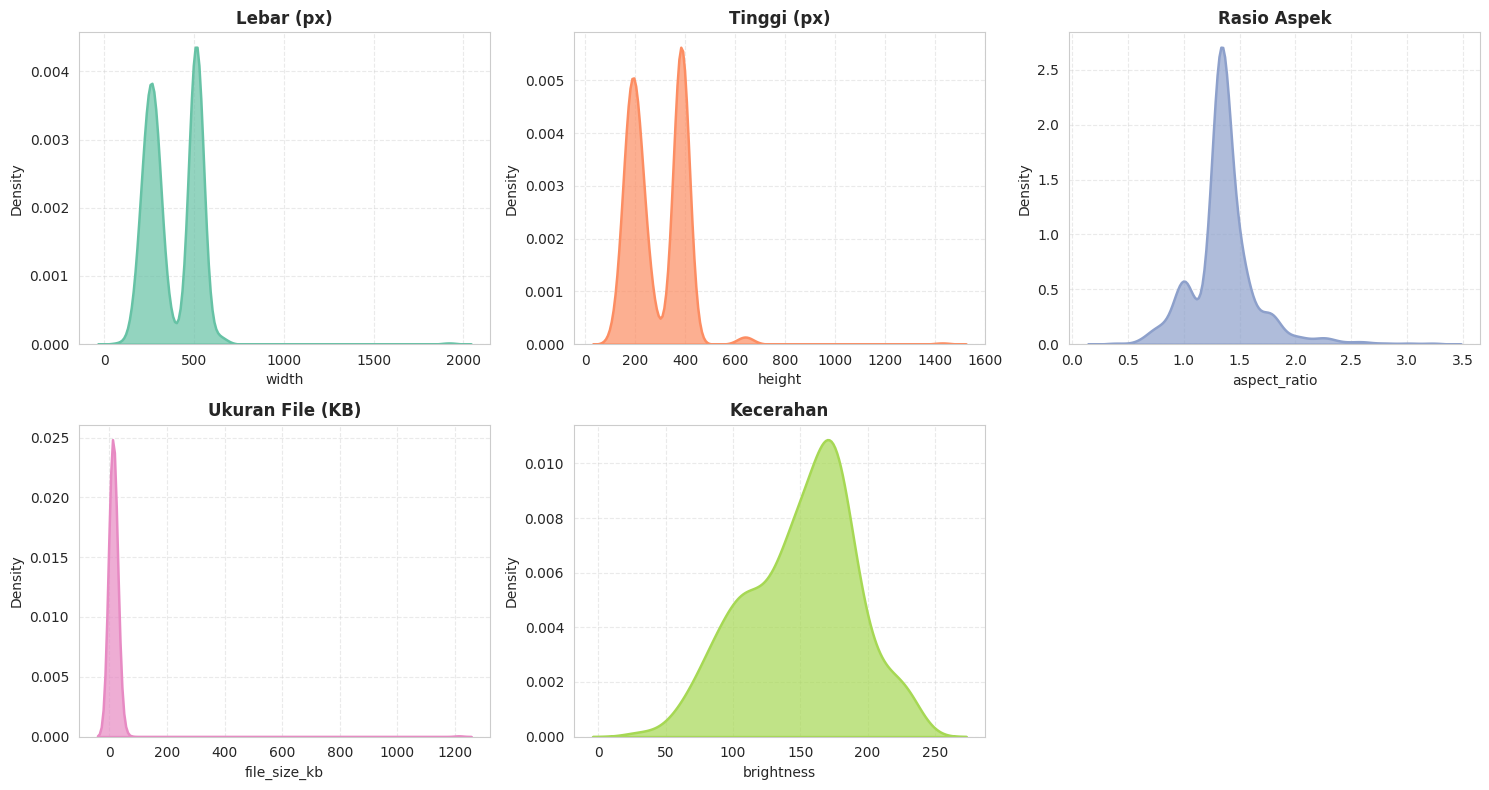

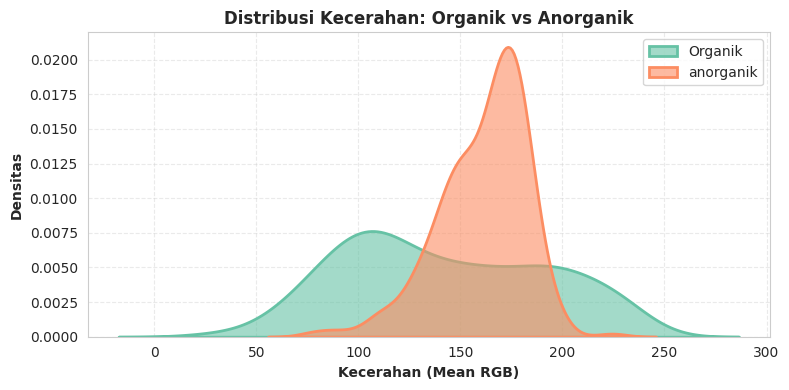

In [ ]:
# ==============================================================================
# 7. ANALISIS KUALITAS GAMBAR
# ==============================================================================
print("\n[2/6] Analisis kualitas gambar...")
df_quality = analyze_image_quality(df_meta, CONFIG["QUALITY_SAMPLE"])

if not df_quality.empty:
    print("\n" + "="*60)
    print("ANALISIS KUALITAS GAMBAR — STATISTIK")
    print("="*60)
    desc = df_quality[['width', 'height', 'aspect_ratio', 'file_size_kb', 'brightness']].describe()
    print(desc.round(2))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
metrics = ['width', 'height', 'aspect_ratio', 'file_size_kb', 'brightness']
titles = ['Lebar (px)', 'Tinggi (px)', 'Rasio Aspek', 'Ukuran File (KB)', 'Kecerahan']
for i, (col, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//3, i%3]
    sns.kdeplot(df_quality[col], ax=ax, fill=True, color=COLORS[i], alpha=0.7, linewidth=1.8)
    ax.set_title(title, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.4)
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
for i, parent in enumerate(df_quality['parent'].unique()):
    data = df_quality[df_quality['parent'] == parent]['brightness']
    sns.kdeplot(data, ax=ax, label=parent, color=COLORS[i], fill=True, alpha=0.6, linewidth=2)
ax.set_xlabel("Kecerahan (Mean RGB)", fontweight='bold')
ax.set_ylabel("Densitas", fontweight='bold')
ax.set_title("Distribusi Kecerahan: Organik vs Anorganik", fontweight='bold')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


[3/6] Menampilkan contoh gambar per subfolder...


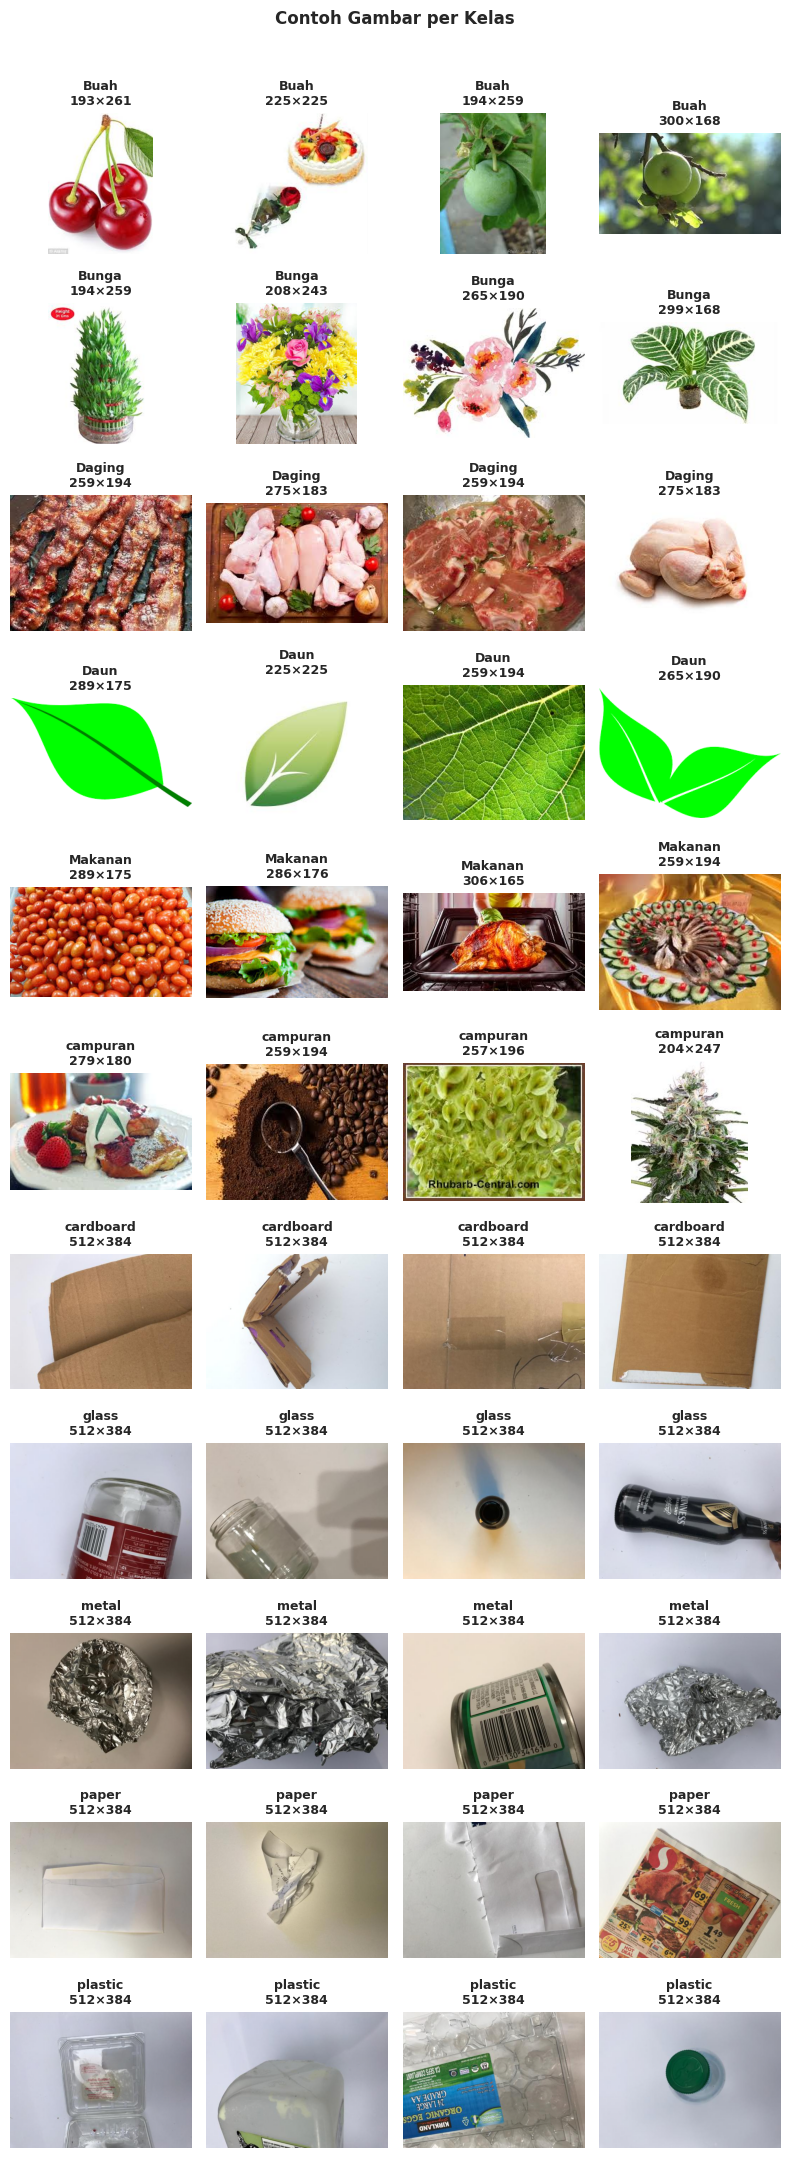

In [ ]:
# ==============================================================================
# 8. TAMPILKAN CONTOH GAMBAR
# ==============================================================================
print("\n[3/6] Menampilkan contoh gambar per subfolder...")
visualize_sample_images(df_meta, CONFIG["VIS_SAMPLES_PER_CLASS"])


PREPROCESSING DATA UNTUK MODEL DEEP LEARNING
Found 3520 images belonging to 2 classes.
Found 880 images belonging to 2 classes.

Generator berhasil dibuat:
   Kelas: ['Organik', 'anorganik']
   Training: 3520 | Validasi: 880

[5/6] Contoh hasil augmentasi data...


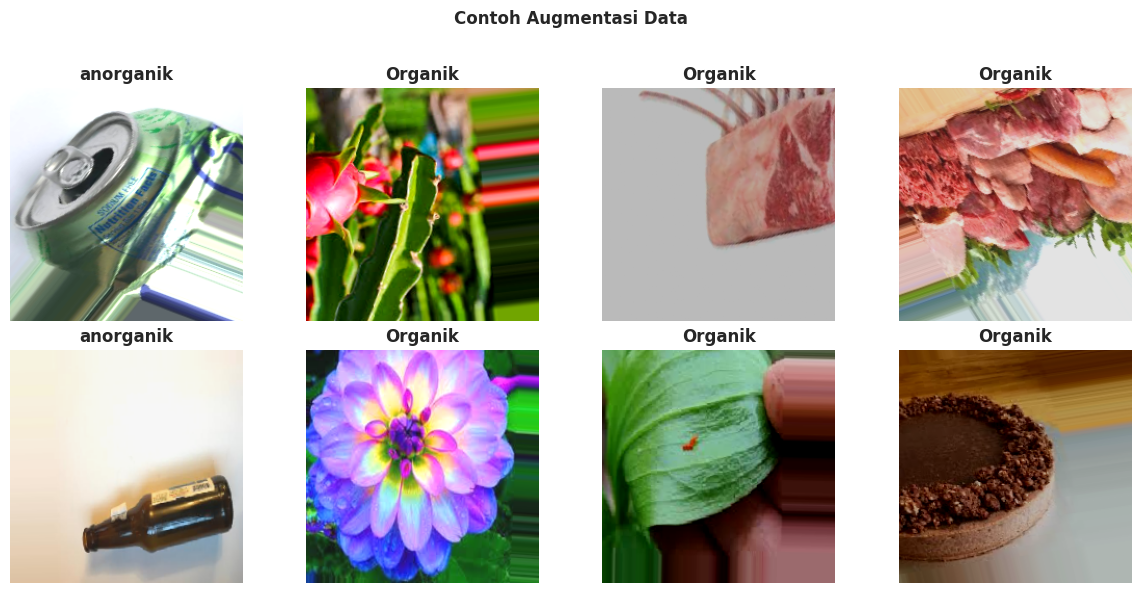

In [ ]:
# ==============================================================================
# 9. PREPROCESSING — GENERATOR DATA & AUGMENTASI
# ==============================================================================
print("\n" + "="*75)
print("PREPROCESSING DATA UNTUK MODEL DEEP LEARNING")
print("="*75)

# Augmentasi diperkuat untuk akurasi maksimal
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=CONFIG["VAL_SPLIT"],
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    channel_shift_range=30.0
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=CONFIG["VAL_SPLIT"])

train_generator = train_datagen.flow_from_directory(
    CONFIG["FLATTENED_DIR"],
    target_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=CONFIG["SEED"]
)

validation_generator = val_datagen.flow_from_directory(
    CONFIG["FLATTENED_DIR"],
    target_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=CONFIG["SEED"]
)

class_names = list(train_generator.class_indices.keys())
print(f"\nGenerator berhasil dibuat:")
print(f"   Kelas: {class_names}")
print(f"   Training: {train_generator.samples} | Validasi: {validation_generator.samples}")

print("\n[5/6] Contoh hasil augmentasi data...")
X_batch, y_batch = next(train_generator)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    ax = axes[i//4, i%4]
    ax.imshow(X_batch[i])
    label = class_names[np.argmax(y_batch[i])]
    ax.set_title(label, fontweight='bold')
    ax.axis('off')
plt.suptitle("Contoh Augmentasi Data", fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


[6/6] VERIFIKASI SPLIT (80% TRAIN / 20% VAL):

Kelas: Organik
  Training → Ekspektasi: 1920, Aktual: 1920
  Validasi → Ekspektasi:  480, Aktual:  480

Kelas: anorganik
  Training → Ekspektasi: 1600, Aktual: 1600
  Validasi → Ekspektasi:  400, Aktual:  400


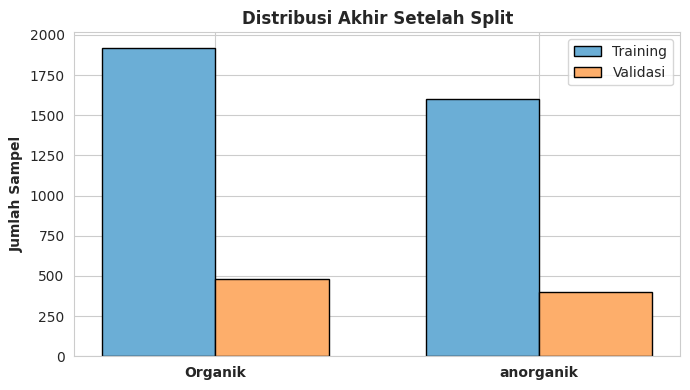

In [ ]:
# ==============================================================================
# 10. VERIFIKASI SPLIT — DISTRIBUSI AKHIR
# ==============================================================================
train_counts = get_class_counts(train_generator)
val_counts = get_class_counts(validation_generator)

total_organik = df_meta[df_meta['parent'] == 'Organik']['count'].sum()
total_anorganik = df_meta[df_meta['parent'] == 'anorganik']['count'].sum()

expected_train = {
    'Organik': int(total_organik * (1 - CONFIG["VAL_SPLIT"])),
    'anorganik': int(total_anorganik * (1 - CONFIG["VAL_SPLIT"]))
}
expected_val = {
    'Organik': total_organik - expected_train['Organik'],
    'anorganik': total_anorganik - expected_train['anorganik']
}

actual_train = dict(zip(class_names, train_counts))
actual_val = dict(zip(class_names, val_counts))

print("\n[6/6] VERIFIKASI SPLIT (80% TRAIN / 20% VAL):")
for cls in class_names:
    print(f"\nKelas: {cls}")
    print(f"  Training → Ekspektasi: {expected_train.get(cls, 0):>4}, Aktual: {actual_train.get(cls, 0):>4}")
    print(f"  Validasi → Ekspektasi: {expected_val.get(cls, 0):>4}, Aktual: {actual_val.get(cls, 0):>4}")

fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(class_names))
width = 0.35
ax.bar(x - width/2, train_counts, width, label='Training', color='#6baed6', edgecolor='black')
ax.bar(x + width/2, val_counts, width, label='Validasi', color='#fdae6b', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontweight='bold')
ax.set_ylabel("Jumlah Sampel", fontweight='bold')
ax.set_title("Distribusi Akhir Setelah Split", fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# 11. RINGKASAN AWAL & SIMPAN DATA
# ==============================================================================
print("\n" + "="*75)
print("RINGKASAN AWAL: DATA SIAP UNTUK PELATIHAN MODEL")
print("="*75)
print(f"• Dataset Path            : {CONFIG['DATASET_DIR']}")
print(f"• Flattened Path          : {CONFIG['FLATTENED_DIR']}")
print(f"• Total Gambar Valid      : {total_valid}")
print(f"• Kelas                   : Organik, anorganik")
print(f"• Resolusi Input          : {CONFIG['IMG_SIZE']}")
print(f"• Normalisasi             : [0, 1]")
print(f"• Augmentasi              : Aktif")
print(f"• Split                   : {train_generator.samples} train / {validation_generator.samples} val")
print(f"• File Corrupt            : 0")

df_meta.to_csv(f"{CONFIG['OUTPUT_DIR']}/dataset_metadata.csv", index=False)
df_quality.to_csv(f"{CONFIG['OUTPUT_DIR']}/image_quality_analysis.csv", index=False)

print(f"\nData disimpan:")
print(f"   - {CONFIG['OUTPUT_DIR']}/dataset_metadata.csv")
print(f"   - {CONFIG['OUTPUT_DIR']}/image_quality_analysis.csv")
print("="*75)

# ==============================================================================
# 12. FUNGSI MODEL & TRAINING YANG DIPERBAIKI
# ==============================================================================
import gc
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications import EfficientNetB0

tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)
gc.collect()
tf.keras.backend.clear_session()

EPOCHS_SCRATCH = 15
EPOCHS_TL = 12
NUM_CLASSES = 2
CLASS_NAMES = ['Organik', 'anorganik']

# Callbacks diperkaya
common_callbacks = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=0),
    callbacks.TerminateOnNaN(),
    callbacks.ModelCheckpoint(
        filepath=f"{CONFIG['OUTPUT_DIR']}/best_model.h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

def create_optimized_scratch_model():
    """Model dari awal yang dioptimalkan untuk akurasi tinggi"""
    inputs = layers.Input(shape=(*CONFIG["IMG_SIZE"], 3))
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return models.Model(inputs, outputs)

def create_optimized_transfer_learning_model():
    """Model transfer learning yang dioptimalkan"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(*CONFIG["IMG_SIZE"], 3)
    )
    base_model.trainable = False

    inputs = layers.Input(shape=(*CONFIG["IMG_SIZE"], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return models.Model(inputs, outputs), base_model

def fine_tune_model(model, base_model, train_gen, val_gen):
    """Fine-tuning dengan unfreeze penuh"""
    base_model.trainable = True
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history_finetune = model.fit(
        train_gen,
        epochs=EPOCHS_TL,
        validation_data=val_gen,
        callbacks=common_callbacks,
        verbose=1
    )
    return history_finetune

def plot_learning_curves(history, title):
    """Plot learning curves"""
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(history.history['accuracy'], 'o-', color='#2ca02c', linewidth=2, markersize=6, label='Training')
    ax[0].plot(history.history['val_accuracy'], 's-', color='#d62728', linewidth=2, markersize=6, label='Validation')
    ax[0].set_title(f'{title} — Akurasi', fontweight='bold')
    ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Akurasi')
    ax[0].legend(); ax[0].grid(True, linestyle='--', alpha=0.5)
    ax[1].plot(history.history['loss'], 'o-', color='#1f77b4', linewidth=2, markersize=6, label='Training')
    ax[1].plot(history.history['val_loss'], 's-', color='#ff7f0e', linewidth=2, markersize=6, label='Validation')
    ax[1].set_title(f'{title} — Loss', fontweight='bold')
    ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Loss')
    ax[1].legend(); ax[1].grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_model_comparison(history_scratch, history_tl):
    """Visualisasi perbandingan model"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes[0,0].plot(history_scratch.history['accuracy'], label='From Scratch (Train)', color='blue', linewidth=2)
    axes[0,0].plot(history_scratch.history['val_accuracy'], label='From Scratch (Val)', color='lightblue', linewidth=2)
    axes[0,0].plot(history_tl.history['accuracy'], label='Transfer Learning (Train)', color='red', linewidth=2)
    axes[0,0].plot(history_tl.history['val_accuracy'], label='Transfer Learning (Val)', color='pink', linewidth=2)
    axes[0,0].set_title('Perbandingan Akurasi Model', fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, linestyle='--', alpha=0.5)
    axes[0,1].plot(history_scratch.history['loss'], label='From Scratch (Train)', color='blue', linewidth=2)
    axes[0,1].plot(history_scratch.history['val_loss'], label='From Scratch (Val)', color='lightblue', linewidth=2)
    axes[0,1].plot(history_tl.history['loss'], label='Transfer Learning (Train)', color='red', linewidth=2)
    axes[0,1].plot(history_tl.history['val_loss'], label='Transfer Learning (Val)', color='pink', linewidth=2)
    axes[0,1].set_title('Perbandingan Loss Model', fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def error_analysis(model, generator, class_names, model_name):
    """Analisis kesalahan klasifikasi"""
    generator.reset()
    Y_pred = model.predict(generator, verbose=0)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = generator.classes
    misclassified_idx = np.where(y_pred != y_true)[0]
    print(f"\n=== ERROR ANALYSIS - {model_name} ===")
    print(f"Total misclassified: {len(misclassified_idx)}/{len(y_true)}")
    print(f"Error rate: {len(misclassified_idx)/len(y_true)*100:.2f}%")
    misclassified_per_class = {}
    for class_idx, class_name in enumerate(class_names):
        class_misclassified = [idx for idx in misclassified_idx if y_true[idx] == class_idx]
        misclassified_per_class[class_name] = {
            'count': len(class_misclassified),
            'total': np.sum(y_true == class_idx),
            'error_rate': len(class_misclassified)/np.sum(y_true == class_idx)*100 if np.sum(y_true == class_idx) > 0 else 0
        }
    for class_name, stats in misclassified_per_class.items():
        print(f"  {class_name}: {stats['count']}/{stats['total']} ({stats['error_rate']:.2f}%)")
    return misclassified_idx, misclassified_per_class

def statistical_analysis_report(y_true_scratch, y_pred_scratch, y_true_tl, y_pred_tl):
    """Analisis statistik mendalam untuk skripsi"""
    print("\n" + "="*60)
    print("ANALISIS STATISTIK UNTUK SKRIPSI")
    print("="*60)
    shapiro_test = stats.shapiro(df_meta['count'])
    print(f"Uji Normalitas Shapiro-Wilk: statistic={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}")
    kappa_scratch = cohen_kappa_score(y_true_scratch, y_pred_scratch)
    kappa_tl = cohen_kappa_score(y_true_tl, y_pred_tl)
    print(f"Cohen's Kappa - From Scratch: {kappa_scratch:.4f}")
    print(f"Cohen's Kappa - Transfer Learning: {kappa_tl:.4f}")
    accuracy_scratch = np.mean(y_true_scratch == y_pred_scratch)
    accuracy_tl = np.mean(y_true_tl == y_pred_tl)
    accuracy_diff = accuracy_tl - accuracy_scratch
    print(f"Akurasi - From Scratch: {accuracy_scratch:.4f}")
    print(f"Akurasi - Transfer Learning: {accuracy_tl:.4f}")
    print(f"Perbedaan Akurasi: {accuracy_diff:.4f}")


RINGKASAN AWAL: DATA SIAP UNTUK PELATIHAN MODEL
• Dataset Path            : /content/Garbage classification
• Flattened Path          : /content/Garbage_classification_flattened
• Total Gambar Valid      : 4400
• Kelas                   : Organik, anorganik
• Resolusi Input          : (224, 224)
• Normalisasi             : [0, 1]
• Augmentasi              : Aktif
• Split                   : 3520 train / 880 val
• File Corrupt            : 0

Data disimpan:
   - /content/output_results/dataset_metadata.csv
   - /content/output_results/image_quality_analysis.csv



MELATIH MODEL DARI AWAL (FROM SCRATCH)
Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7967 - loss: 0.5207

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 497ms/step - accuracy: 0.7971 - loss: 0.5198 - val_accuracy: 0.4557 - val_loss: 0.8445 - learning_rate: 0.0010
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8857 - loss: 0.3134

110/110 ━━━━━━━━━━━━━━━━━━━━ 56s 506ms/step - accuracy: 0.8857 - loss: 0.3134 - val_accuracy: 0.4682 - val_loss: 1.3567 - learning_rate: 0.0010
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8871 - loss: 0.3122

110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 473ms/step - accuracy: 0.8871 - loss: 0.3122 - val_accuracy: 0.5318 - val_loss: 1.0800 - learning_rate: 0.0010
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9054 - loss: 0.2745

110/110 ━━━━━━━━━━━━━━━━━━━━ 53s 479ms/step - accuracy: 0.9054 - loss: 0.2746 - val_accuracy: 0.7239 - val_loss: 0.6734 - learning_rate: 0.0010
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 490ms/step - accuracy: 0.9076 - loss: 0.2594 - val_accuracy: 0.6068 - val_loss: 0.7278 - learning_rate: 0.0010
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8992 - loss: 0.2590

110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 476ms/step - accuracy: 0.8992 - loss: 0.2589 - val_accuracy: 0.7943 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 472ms/step - accuracy: 0.9167 - loss: 0.2373 - val_accuracy: 0.6114 - val_loss: 0.8699 - learning_rate: 0.0010
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 53s 484ms/step - accuracy: 0.9065 - loss: 0.2528 - val_accuracy: 0.5534 - val_loss: 1.2071 - learning_rate: 0.0010
Epoch 9/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9151 - loss: 0.2214

110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 473ms/step - accuracy: 0.9151 - loss: 0.2215 - val_accuracy: 0.8670 - val_loss: 0.3643 - learning_rate: 0.0010
Epoch 10/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 472ms/step - accuracy: 0.9065 - loss: 0.2368 - val_accuracy: 0.6125 - val_loss: 0.8514 - learning_rate: 0.0010
Epoch 11/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 487ms/step - accuracy: 0.9134 - loss: 0.2278 - val_accuracy: 0.5455 - val_loss: 2.1291 - learning_rate: 0.0010
Epoch 12/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 472ms/step - accuracy: 0.9071 - loss: 0.2427 - val_accuracy: 0.5477 - val_loss: 2.0493 - learning_rate: 0.0010
Epoch 13/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9194 - loss: 0.2111

110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 472ms/step - accuracy: 0.9195 - loss: 0.2111 - val_accuracy: 0.9364 - val_loss: 0.1953 - learning_rate: 5.0000e-04
Epoch 14/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 493ms/step - accuracy: 0.9313 - loss: 0.1987 - val_accuracy: 0.8420 - val_loss: 0.4219 - learning_rate: 5.0000e-04
Epoch 15/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 53s 480ms/step - accuracy: 0.9283 - loss: 0.1881 - val_accuracy: 0.7580 - val_loss: 0.5596 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 13.


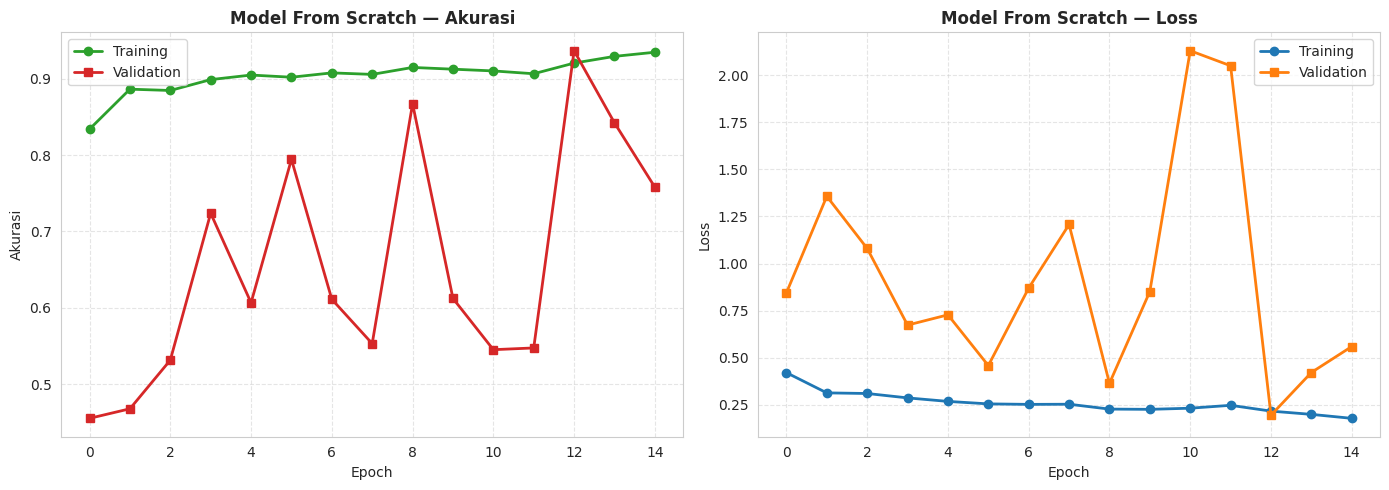


EVALUASI MODEL: FROM SCRATCH
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

=== Classification Report (From Scratch) ===
              precision    recall  f1-score   support

     Organik       0.93      0.96      0.94       480
   anorganik       0.95      0.91      0.93       400

    accuracy                           0.94       880
   macro avg       0.94      0.93      0.94       880
weighted avg       0.94      0.94      0.94       880



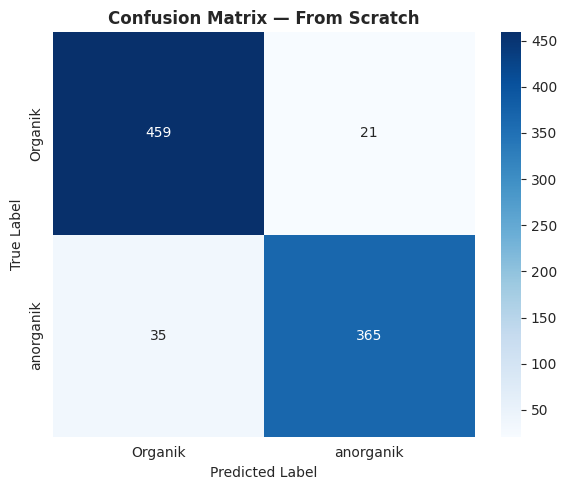


=== ERROR ANALYSIS - FROM SCRATCH ===
Total misclassified: 56/880
Error rate: 6.36%
  Organik: 21/480 (4.38%)
  anorganik: 35/400 (8.75%)


In [ ]:
# ==============================================================================
# 13. PELATIHAN MODEL — FROM SCRATCH
# ==============================================================================
print("\n" + "="*75)
print("MELATIH MODEL DARI AWAL (FROM SCRATCH)")
print("="*75)

train_generator.reset()
validation_generator.reset()

model_scratch = create_optimized_scratch_model()
model_scratch.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_scratch = model_scratch.fit(
    train_generator,
    epochs=EPOCHS_SCRATCH,
    validation_data=validation_generator,
    callbacks=common_callbacks,
    verbose=1
)

train_generator.reset()
validation_generator.reset()
plot_learning_curves(history_scratch, "Model From Scratch")

print("\n" + "="*60)
print("EVALUASI MODEL: FROM SCRATCH")
print("="*60)

validation_generator.reset()
Y_pred_scratch = model_scratch.predict(validation_generator, verbose=1)
y_pred_scratch = np.argmax(Y_pred_scratch, axis=1)
y_true_scratch = validation_generator.classes

print("\n=== Classification Report (From Scratch) ===")
print(classification_report(y_true_scratch, y_pred_scratch, target_names=CLASS_NAMES))

cm_scratch = confusion_matrix(y_true_scratch, y_pred_scratch)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix — From Scratch", fontweight='bold')
plt.ylabel("True Label"); plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

misclassified_scratch, error_stats_scratch = error_analysis(model_scratch, validation_generator, CLASS_NAMES, "FROM SCRATCH")


MELATIH MODEL DENGAN TRANSFER LEARNING
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 96s 610ms/step - accuracy: 0.5296 - loss: 1.0643 - val_accuracy: 0.5455 - val_loss: 0.7288 - learning_rate: 0.0010
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 461ms/step - accuracy: 0.5731 - loss: 0.8450 - val_accuracy: 0.5455 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 492ms/step - accuracy: 0.5621 - loss: 0.8029 - val_accuracy: 0.5455 - val_loss: 0.7160 - learning_rate: 0.0010
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 53s 484ms/step - accuracy: 0.5848 - loss: 0.7792 - val_accuracy: 0.5432 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 470ms/step - accuracy: 0.5772 - loss: 0.7599 - val_accuracy: 0.5386 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 1/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 143s 595ms/step - accuracy: 0.5896 - loss: 0.8081 - val_accuracy: 0.4545 - val_loss: 0.9762 - learn

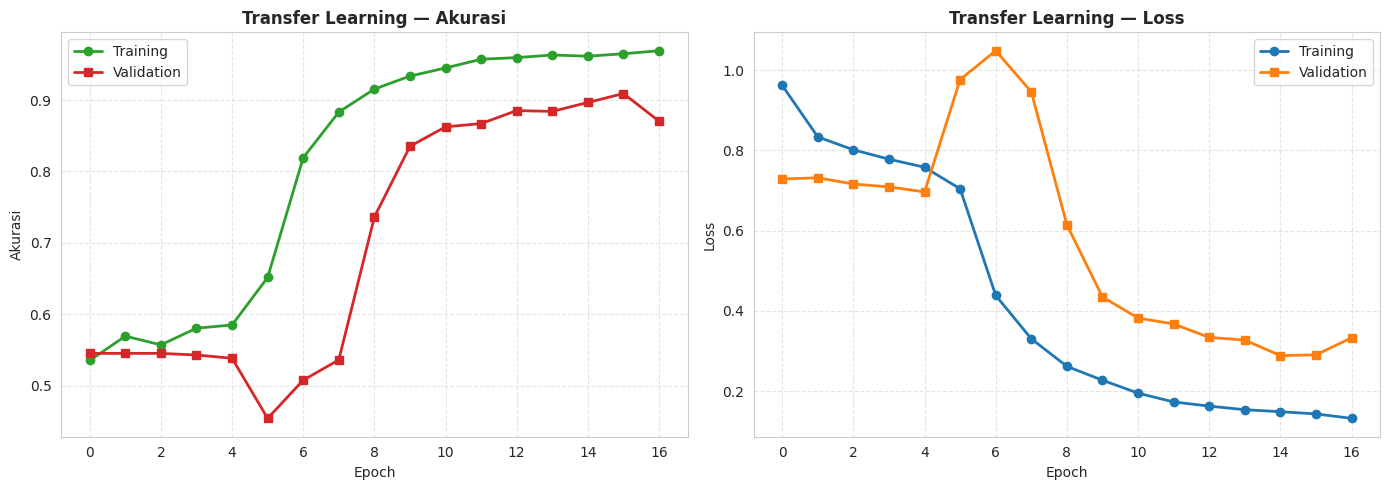


EVALUASI MODEL: TRANSFER LEARNING
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 305ms/step

=== Classification Report (Transfer Learning) ===
              precision    recall  f1-score   support

     Organik       0.92      0.91      0.92       480
   anorganik       0.89      0.91      0.90       400

    accuracy                           0.91       880
   macro avg       0.91      0.91      0.91       880
weighted avg       0.91      0.91      0.91       880



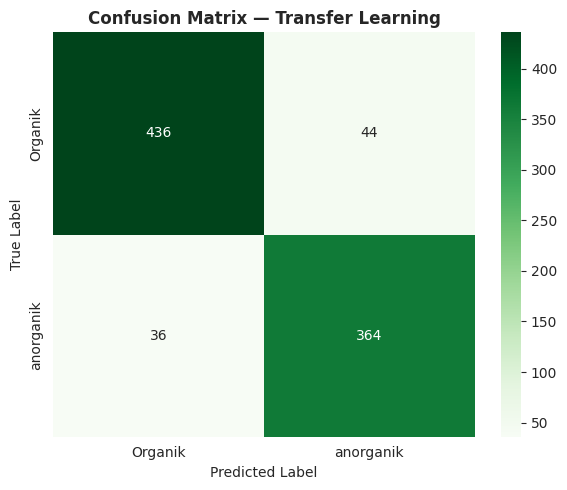


=== ERROR ANALYSIS - TRANSFER LEARNING ===
Total misclassified: 80/880
Error rate: 9.09%
  Organik: 44/480 (9.17%)
  anorganik: 36/400 (9.00%)


In [ ]:
# ==============================================================================
# 14. PELATIHAN MODEL — TRANSFER LEARNING
# ==============================================================================
print("\n" + "="*75)
print("MELATIH MODEL DENGAN TRANSFER LEARNING")
print("="*75)

train_generator.reset()
validation_generator.reset()

model_tl, base_model = create_optimized_transfer_learning_model()
model_tl.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Phase 1: Train head
history_phase1 = model_tl.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ],
    verbose=1
)

# Phase 2: Fine-tune
history_phase2 = fine_tune_model(model_tl, base_model, train_generator, validation_generator)

# Gabungkan history
combined_history = {}
for key in history_phase1.history.keys():
    combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history_tl = MockHistory(combined_history)

train_generator.reset()
validation_generator.reset()
plot_learning_curves(history_tl, "Transfer Learning")

print("\n" + "="*60)
print("EVALUASI MODEL: TRANSFER LEARNING")
print("="*60)

validation_generator.reset()
Y_pred_tl = model_tl.predict(validation_generator, verbose=1)
y_pred_tl = np.argmax(Y_pred_tl, axis=1)
y_true_tl = validation_generator.classes

print("\n=== Classification Report (Transfer Learning) ===")
print(classification_report(y_true_tl, y_pred_tl, target_names=CLASS_NAMES))

cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Greens', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix — Transfer Learning", fontweight='bold')
plt.ylabel("True Label"); plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

misclassified_tl, error_stats_tl = error_analysis(model_tl, validation_generator, CLASS_NAMES, "TRANSFER LEARNING")


ANALISIS PERBANDINGAN MODEL


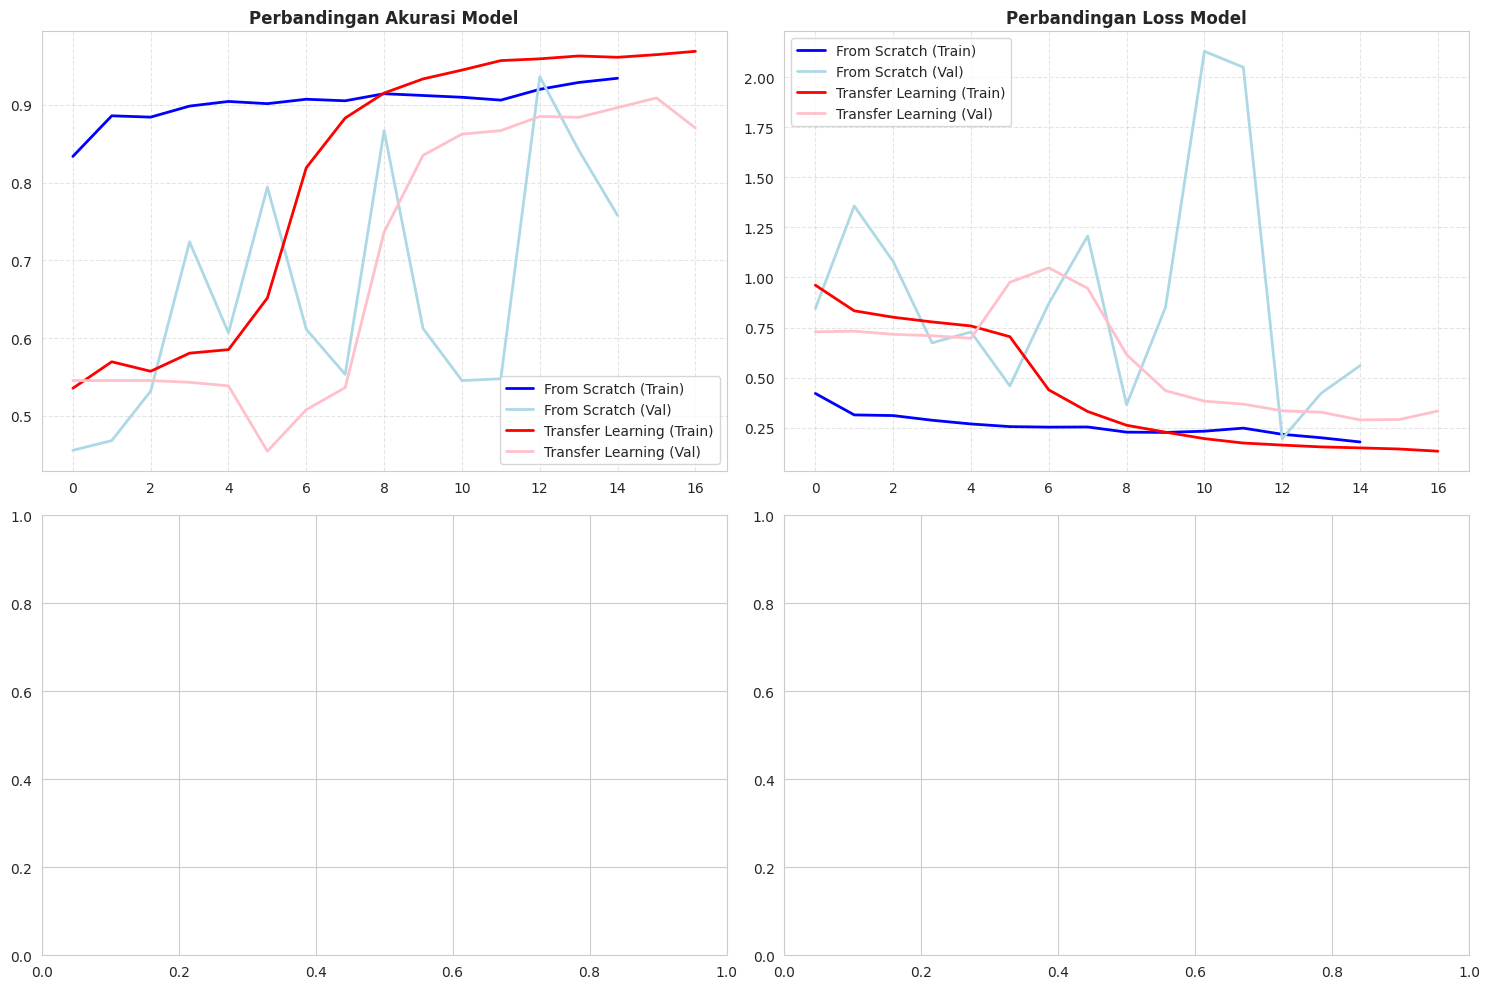


ANALISIS STATISTIK UNTUK SKRIPSI
Uji Normalitas Shapiro-Wilk: statistic=1.0000, p-value=1.0000
Cohen's Kappa - From Scratch: 0.8713
Cohen's Kappa - Transfer Learning: 0.8170
Akurasi - From Scratch: 0.9364
Akurasi - Transfer Learning: 0.9091
Perbedaan Akurasi: -0.0273


In [ ]:
# ==============================================================================
# 15. ANALISIS PERBANDINGAN DAN STATISTIK
# ==============================================================================
print("\n" + "="*75)
print("ANALISIS PERBANDINGAN MODEL")
print("="*75)

plot_model_comparison(history_scratch, history_tl)
statistical_analysis_report(y_true_scratch, y_pred_scratch, y_true_tl, y_pred_tl)


In [ ]:
# ==============================================================================
# 16. SIMPAN HASIL DAN MODEL
# ==============================================================================
print("\n" + "="*75)
print("MENYIMPAN HASIL DAN MODEL")
print("="*75)

cr_scratch_df = pd.DataFrame(classification_report(y_true_scratch, y_pred_scratch, target_names=CLASS_NAMES, output_dict=True)).transpose()
cr_tl_df = pd.DataFrame(classification_report(y_true_tl, y_pred_tl, target_names=CLASS_NAMES, output_dict=True)).transpose()

cr_scratch_df.to_csv(f"{CONFIG['OUTPUT_DIR']}/classification_report_scratch.csv", index=False)
cr_tl_df.to_csv(f"{CONFIG['OUTPUT_DIR']}/classification_report_transfer_learning.csv", index=False)

cm_scratch_df = pd.DataFrame(cm_scratch, index=CLASS_NAMES, columns=CLASS_NAMES)
cm_tl_df = pd.DataFrame(cm_tl, index=CLASS_NAMES, columns=CLASS_NAMES)

cm_scratch_df.to_csv(f"{CONFIG['OUTPUT_DIR']}/confusion_matrix_scratch.csv")
cm_tl_df.to_csv(f"{CONFIG['OUTPUT_DIR']}/confusion_matrix_transfer_learning.csv")

model_tl.save(f"{CONFIG['OUTPUT_DIR']}/model_efficientnetb0_waste_classifier.h5")
print("Model transfer learning disimpan")

print(f"\nSemua hasil disimpan di: {CONFIG['OUTPUT_DIR']}")


MENYIMPAN HASIL DAN MODEL
Model transfer learning disimpan

Semua hasil disimpan di: /content/output_results


In [ ]:
# ==============================================================================
# 17. KONVERSI MODEL UNTUK DEPLOYMENT
# ==============================================================================
print("\n" + "="*75)
print("KONVERSI MODEL UNTUK IMPLEMENTASI WEB")
print("="*75)

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model_tl)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    with open(f"{CONFIG['OUTPUT_DIR']}/model_waste_classifier.tflite", "wb") as f:
        f.write(tflite_model)
    print("Model TFLite disimpan")
    model_tl.save(f"{CONFIG['OUTPUT_DIR']}/model_waste_classifier.keras")
    print("Model Keras format disimpan")
except Exception as e:
    print(f"Konversi model gagal: {e}")


KONVERSI MODEL UNTUK IMPLEMENTASI WEB
Saved artifact at '/tmp/tmpkr4wha4z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_253')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132771892219920: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132771892221456: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132771933169680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132771930847760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132771930842384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132771933167568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132771930846416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132771930845648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132771930844688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132771930844880: Tensor

In [ ]:
# ==============================================================================
# 18. BUAT FILE ZIP DENGAN SEMUA HASIL
# ==============================================================================
print("\n" + "="*75)
print("MEMBUAT FILE ZIP DENGAN SEMUA HASIL")
print("="*75)

import zipfile
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f"/content/waste_classification_results_{timestamp}.zip"

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(CONFIG['OUTPUT_DIR']):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, CONFIG['OUTPUT_DIR'])
            zipf.write(file_path, arcname)

print(f"File zip berhasil dibuat: {zip_filename}")


MEMBUAT FILE ZIP DENGAN SEMUA HASIL
File zip berhasil dibuat: /content/waste_classification_results_20251025_061258.zip


In [ ]:
# ==============================================================================
# 19. RINGKASAN AKHIR
# ==============================================================================
print("\n" + "="*75)
print("SELESAI — SEMUA TAHAP TELAH DILAKUKAN")
print("="*75)

final_accuracy_scratch = np.mean(y_true_scratch == y_pred_scratch)
final_accuracy_tl = np.mean(y_true_tl == y_pred_tl)

print(f"HASIL AKHIR:")
print(f"   • From Scratch Accuracy     : {final_accuracy_scratch:.4f} ({final_accuracy_scratch*100:.2f}%)")
print(f"   • Transfer Learning Accuracy: {final_accuracy_tl:.4f} ({final_accuracy_tl*100:.2f}%)")
print(f"   • Peningkatan               : {final_accuracy_tl - final_accuracy_scratch:.4f} ({(final_accuracy_tl - final_accuracy_scratch)*100:.2f}%)")

print(f"\nOUTPUT YANG DIHASILKAN:")
print(f"   • Dataset Metadata          : {CONFIG['OUTPUT_DIR']}/dataset_metadata.csv")
print(f"   • Image Quality Analysis    : {CONFIG['OUTPUT_DIR']}/image_quality_analysis.csv")
print(f"   • Classification Reports    : {CONFIG['OUTPUT_DIR']}/classification_report_*.csv")
print(f"   • Confusion Matrices        : {CONFIG['OUTPUT_DIR']}/confusion_matrix_*.csv")
print(f"   • Model Files               : {CONFIG['OUTPUT_DIR']}/model_*")
print(f"   • Zip File                  : {zip_filename}")

print("\nEksperimen selesai. Semua data dan model telah disimpan.")
print("="*75)


SELESAI — SEMUA TAHAP TELAH DILAKUKAN
HASIL AKHIR:
   • From Scratch Accuracy     : 0.9364 (93.64%)
   • Transfer Learning Accuracy: 0.9091 (90.91%)
   • Peningkatan               : -0.0273 (-2.73%)

OUTPUT YANG DIHASILKAN:
   • Dataset Metadata          : /content/output_results/dataset_metadata.csv
   • Image Quality Analysis    : /content/output_results/image_quality_analysis.csv
   • Classification Reports    : /content/output_results/classification_report_*.csv
   • Confusion Matrices        : /content/output_results/confusion_matrix_*.csv
   • Model Files               : /content/output_results/model_*
   • Zip File                  : /content/waste_classification_results_20251025_061258.zip

Eksperimen selesai. Semua data dan model telah disimpan.
